In [202]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:

# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

--2024-05-06 09:07:54--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  12.6MB/s    in 2m 6s   

2024-05-06 09:10:02 (11.7 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [6]:
!rm -rf ./images


In [7]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = [d for d in os.listdir(base_dir)]
for cl in classes:
  raw_no_of_files[cl] = len(os.listdir(os.path.join(base_dir, cl)))
raw_no_of_files.items()

dict_items([('rocket', 1186), ('helicopter', 1387), ('missile', 1334), ('fighter-jet', 1867), ('drone', 1332), ('passenger-plane', 1424)])

In [8]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')
train_helicopter_dir = os.path.join(train_dir, 'helicopter')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')
test_helicopter_dir = os.path.join(test_dir, 'helicopter')

dirs = [train_drone_dir, train_passenger_dir, train_helicopter_dir,
        valid_drone_dir, valid_passenger_dir, valid_helicopter_dir,
        test_drone_dir, test_passenger_dir, test_helicopter_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [9]:
drone_fnames = [name for name in os.listdir(os.path.join(base_dir, 'drone')) if name.lower().split('.')[1] in ['jpg', 'jpeg', 'png']]
passenger_fnames = [name for name in os.listdir(os.path.join(base_dir, 'passenger-plane')) if name.lower().split('.')[1] in ['jpg', 'jpeg', 'png']]
helicopter_fnames = [name for name in os.listdir(os.path.join(base_dir, 'helicopter')) if name.lower().split('.')[1] in ['jpg', 'jpeg', 'png']]

In [10]:
size = min(len(drone_fnames), len(passenger_fnames), len(helicopter_fnames))
size

1312

In [11]:
train_idx = int(np.ceil(size*0.7))
valid_idx = int(np.ceil(size*0.2)) + train_idx
test_idx = size

print(train_idx, valid_idx, test_idx)

919 1182 1312


In [207]:

for idx, fname in enumerate(drone_fnames):
  if idx <=train_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(train_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < idx < valid_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(valid_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < idx < test_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(test_drone_dir, fname)
    shutil.copyfile(src, dst)

for idx, fname in enumerate(passenger_fnames):
  if idx <= train_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(train_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < idx < valid_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(valid_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < idx < test_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(test_passenger_dir, fname)
    shutil.copyfile(src, dst)

for idx, fname in enumerate(helicopter_fnames):
  if idx <= train_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(train_helicopter_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < idx < valid_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(valid_helicopter_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < idx < test_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(test_helicopter_dir, fname)
    shutil.copyfile(src, dst)

In [123]:
print('Liczba dronów - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('Liczba dronów - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('Liczba dronów - zbiór testowy', len(os.listdir(test_drone_dir)))

print('Liczba samolotów - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('Liczba samolotów - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('Liczba samolotów - zbiór testowy', len(os.listdir(test_passenger_dir)))

print('Liczba helikopterów - zbiór treningowy', len(os.listdir(train_helicopter_dir)))
print('Liczba helikopterów - zbiór walidacyjny', len(os.listdir(valid_helicopter_dir)))
print('Liczba helikopterów - zbiór testowy', len(os.listdir(test_helicopter_dir)))

Liczba dronów - zbiór treningowy 920
Liczba dronów - zbiór walidacyjny 262
Liczba dronów - zbiór testowy 115
Liczba samolotów - zbiór treningowy 920
Liczba samolotów - zbiór walidacyjny 262
Liczba samolotów - zbiór testowy 115
Liczba helikopterów - zbiór treningowy 920
Liczba helikopterów - zbiór walidacyjny 262
Liczba helikopterów - zbiór testowy 115


(-0.5, 5311.5, 2987.5, -0.5)

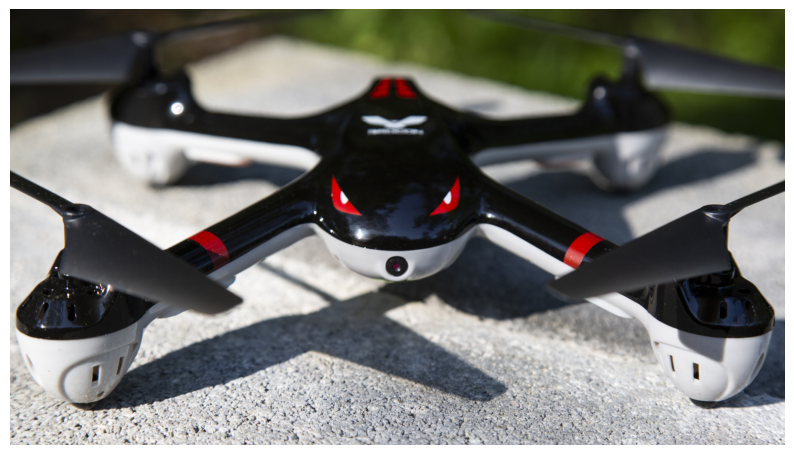

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 569 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 294.5, 199.5, -0.5)

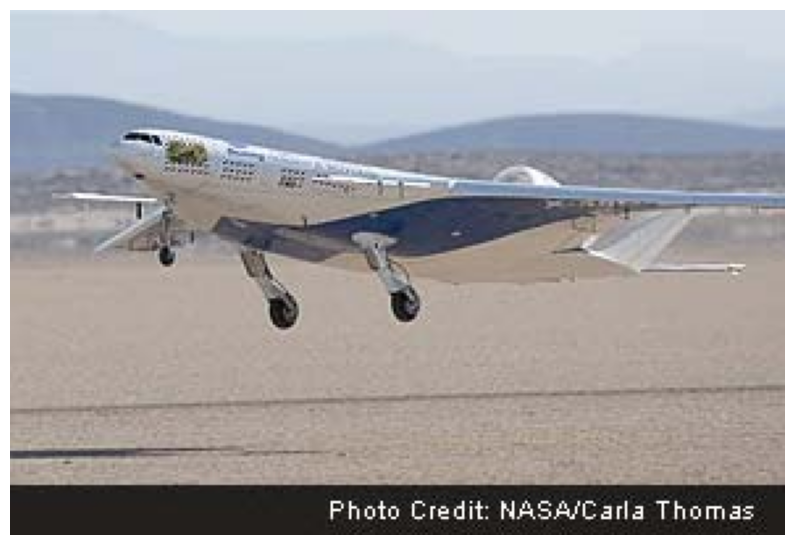

In [ ]:

#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 518 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 748.5, 505.5, -0.5)

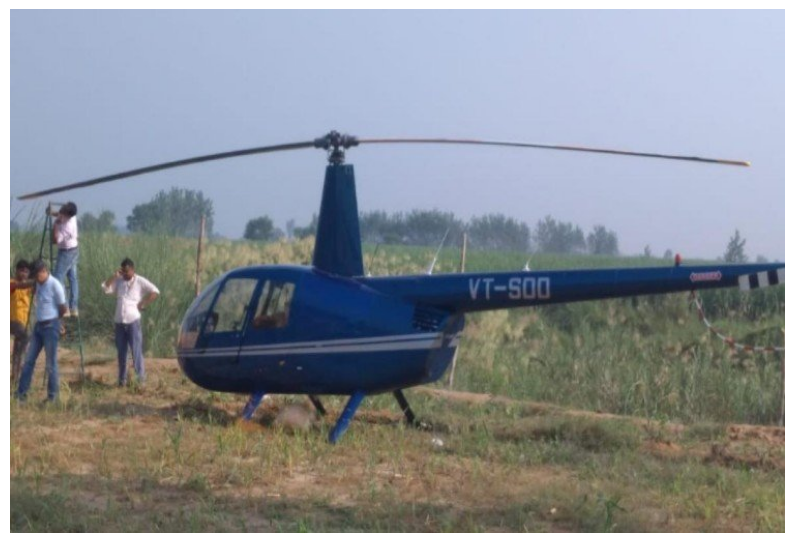

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia helikoptera ze zbioru treningowego:

idx = 219 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(helicopter_fnames))
img_path = os.path.join(train_helicopter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [14]:

def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

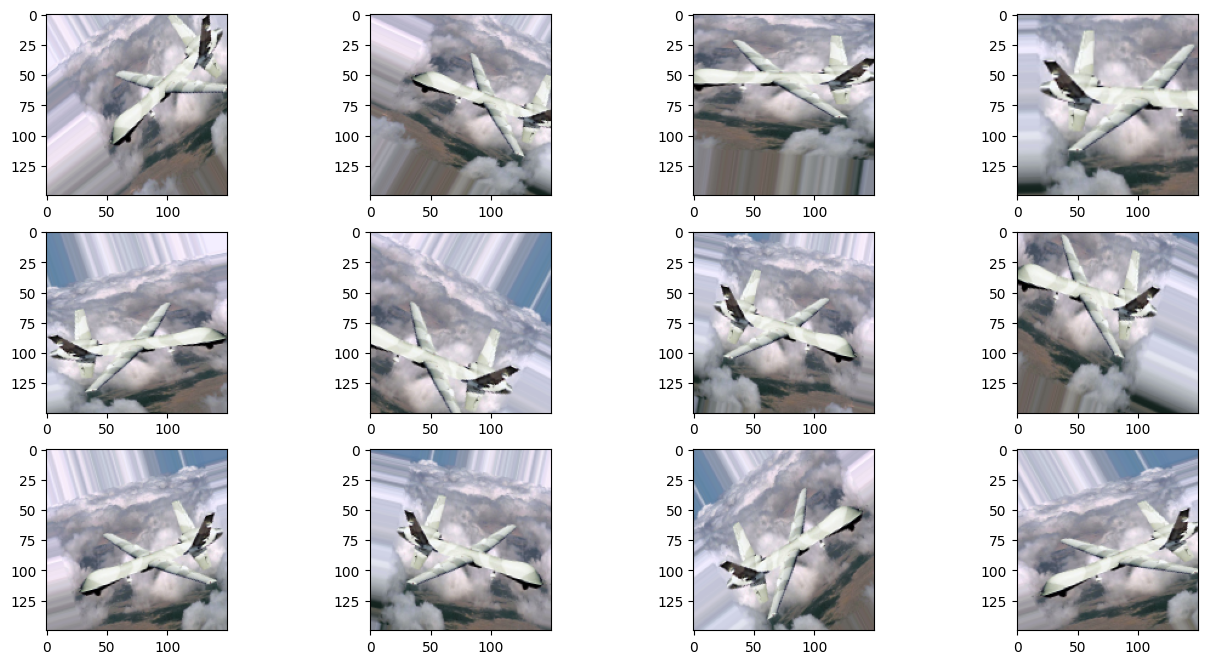

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
#@title Zbiór treningowy drone:
idx = 83 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

In [16]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80134624/80134624 [==============================] - 4s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [17]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [158]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

In [128]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22122563 (84.39 MB)
Trainable params: 11537411 (44.01 MB)
Non-trainable params: 10585152 (40.38 MB)
_________________________________________________________________


In [129]:
print('Liczba wag poddawanych trenowaniu po zamrożeniu bazy', len(model.trainable_weights))

Liczba wag poddawanych trenowaniu po zamrożeniu bazy 12


In [130]:
train_size =  len(os.listdir(train_helicopter_dir))
valid_size = len(os.listdir(valid_helicopter_dir))

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [131]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [132]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2760 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


In [133]:
history = model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

Epoch 1/50
28/28 [==============================] - 23s 772ms/step - loss: 0.8144 - accuracy: 0.6083 - val_loss: 0.5743 - val_accuracy: 0.7969
Epoch 2/50
28/28 [==============================] - 18s 653ms/step - loss: 0.5491 - accuracy: 0.7764 - val_loss: 0.5294 - val_accuracy: 0.7617
Epoch 3/50
28/28 [==============================] - 19s 683ms/step - loss: 0.4983 - accuracy: 0.7924 - val_loss: 0.4638 - val_accuracy: 0.8125
Epoch 4/50
28/28 [==============================] - 19s 685ms/step - loss: 0.4896 - accuracy: 0.7924 - val_loss: 0.4778 - val_accuracy: 0.7969
Epoch 5/50
28/28 [==============================] - 19s 687ms/step - loss: 0.4977 - accuracy: 0.7868 - val_loss: 0.4713 - val_accuracy: 0.8008
Epoch 6/50
28/28 [==============================] - 19s 672ms/step - loss: 0.4415 - accuracy: 0.8192 - val_loss: 0.5240 - val_accuracy: 0.8008
Epoch 7/50
28/28 [==============================] - 19s 692ms/step - loss: 0.4440 - accuracy: 0.8147 - val_loss: 0.4043 - val_accuracy: 0.8711

In [ ]:
%load_ext tensorboard

In [134]:
hist = pd.DataFrame(history.history)
hist

loss  accuracy  val_loss  val_accuracy
0   0.814395  0.608259  0.574282      0.796875
1   0.549127  0.776376  0.529398      0.761719
2   0.498327  0.792411  0.463797      0.812500
3   0.489557  0.792431  0.477832      0.796875
4   0.497749  0.786830  0.471342      0.800781
5   0.441522  0.819196  0.524014      0.800781
6   0.444038  0.814732  0.404291      0.871094
7   0.396489  0.842634  0.463446      0.824219
8   0.417028  0.832569  0.480210      0.824219
9   0.406586  0.838170  0.496737      0.816406
10  0.407849  0.825893  0.451724      0.832031
11  0.373428  0.853795  0.462256      0.839844
12  0.408750  0.847098  0.583242      0.761719
13  0.391336  0.849330  0.523610      0.812500
14  0.362081  0.857143  0.466030      0.816406
15  0.341830  0.869266  0.486669      0.796875
16  0.381413  0.848214  0.497245      0.804688
17  0.345402  0.861607  0.423446      0.820312
18  0.390756  0.850446  0.475064      0.832031
19  0.354133  0.865826  0.491207      0.816406
20  0.374024  0.859375  0.467324      0.804688
21  0.329271  0.866071  0.461826      0.839844
22  0.331791  0.863532  0.549150      0.808594
23  0.284978  0.892857  0.537833      0.812500
24  0.340011  0.852679  0.339427      0.851562
25  0.350906  0.850446  0.531405      0.796875
26  0.349654  0.870413  0.436861      0.847656
27  0.298428  0.891055  0.433681      0.832031
28  0.343360  0.872768  0.461347      0.800781
29  0.284074  0.895089  0.466209      0.835938
30  0.283738  0.886161  0.529419      0.828125
31  0.279409  0.888761  0.475958      0.828125
32  0.282198  0.878348  0.409548      0.855469
33  0.286676  0.895089  0.546282      0.812500
34  0.276841  0.900229  0.464535      0.824219
35  0.318661  0.875000  0.550973      0.820312
36  0.282636  0.890625  0.652232      0.796875
37  0.299024  0.888393  0.471477      0.820312
38  0.284758  0.894495  0.671790      0.792969
39  0.293773  0.886161  0.475851      0.820312
40  0.289977  0.891055  0.438442      0.839844
41  0.273935  0.891055  0.507578      0.828125
42  0.257225  0.906250  0.478662      0.843750
43  0.281575  0.881881  0.413753      0.835938
44  0.262502  0.900229  0.487252      0.835938
45  0.266362  0.894495  0.517637      0.812500
46  0.280587  0.903670  0.461358      0.828125
47  0.256929  0.908482  0.670948      0.773438
48  0.245835  0.892857  0.540326      0.820312
49  0.231248  0.908482  0.580808      0.835938

In [135]:

def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [136]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob

Found 345 images belonging to 3 classes.
345/345 [==============================] - 4s 13ms/step


array([[0.999547, 0.000452, 0.000001],
       [0.99954 , 0.000339, 0.000121],
       [0.999842, 0.000148, 0.00001 ],
       ...,
       [0.001572, 0.003498, 0.994931],
       [0.      , 0.      , 1.      ],
       [0.001006, 0.000263, 0.998731]], dtype=float32)

In [137]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [77]:
len(y_pred)

387

In [138]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [139]:
predictions = pd.DataFrame({'y_prob_0': y_prob[:,0], 'y_prob_1': y_prob[:,1], 'y_prob_2': y_prob[:,2],'y_pred':y_pred})
predictions

y_prob_0      y_prob_1      y_prob_2  y_pred
0    9.995471e-01  4.521254e-04  8.630704e-07       0
1    9.995397e-01  3.394811e-04  1.207744e-04       0
2    9.998418e-01  1.484107e-04  9.758924e-06       0
3    9.458826e-01  1.709975e-04  5.394642e-02       0
4    6.910512e-01  1.395253e-01  1.694235e-01       0
..            ...           ...           ...     ...
340  1.098183e-05  1.335030e-06  9.999877e-01       2
341  1.007938e-01  4.504243e-04  8.987558e-01       2
342  1.571576e-03  3.497514e-03  9.949309e-01       2
343  1.805908e-08  3.063135e-07  9.999996e-01       2
344  1.006471e-03  2.625345e-04  9.987310e-01       2

[345 rows x 4 columns]

In [140]:
y_pred = predictions['y_pred'].values

In [141]:
cm = confusion_matrix(y_true, y_pred)

In [142]:
classes = ['drone', 'helicopter', 'passenger-plane']

In [143]:


def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [144]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
drone/00000000.jpg           0       0
drone/00000005.jpg           0       0
drone/00000013.jpg           0       0
drone/00000026.png           0       0
drone/00000044.jpg           0       0
...                        ...     ...
passenger/00001428.jpg       2       2
passenger/00001444.jpg       2       2
passenger/00001448.jpg       2       2
passenger/00001457.jpg       2       2
passenger/00001473.jpg       2       2

[345 rows x 2 columns]

In [145]:
errors['is_incorrect'] = np.where(errors['y_true']!=errors['y_pred'], 1, 0)
errors[errors['is_incorrect']==1]

y_true  y_pred  is_incorrect
drone/00000314.jpg            0       2             1
drone/00000697.jpg            0       2             1
drone/00000782.jpg            0       2             1
drone/00000828.jpg            0       2             1
drone/00000938.png            0       2             1
drone/00000978.jpg            0       1             1
drone/00000990.jpg            0       2             1
drone/00001025.jpg            0       2             1
drone/00001180.jpg            0       1             1
drone/00001217.jpg            0       2             1
drone/00001221.jpeg           0       2             1
drone/00001283.jpg            0       2             1
drone/00001300.jpg            0       2             1
drone/00001412.jpg            0       2             1
helicopter/00000421.jpg       1       2             1
helicopter/00000949.JPG       1       2             1
passenger/00000110.jpg        2       1             1
passenger/00000752.jpg        2       0             1
passenger/00000784.jpg        2       0             1
passenger/00000789.jpg        2       0             1
passenger/00001050.jpg        2       0             1
passenger/00001270.png        2       0             1
passenger/00001272.jpg        2       1             1

(-0.5, 628.5, 449.5, -0.5)

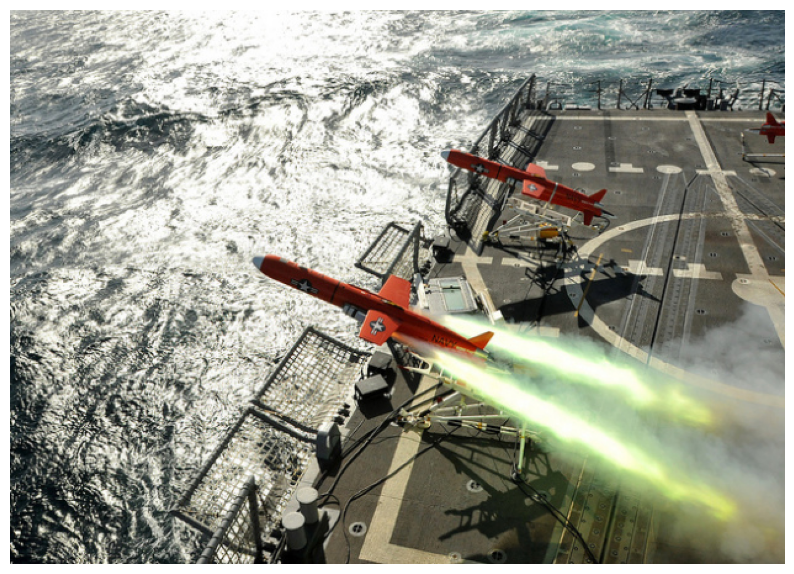

In [147]:

img_path = os.path.join(test_drone_dir, '00001180.jpg')
img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [71]:
errors[errors['is_incorrect']==1].index

Index(['drone/00000219.jpg', 'drone/00000250.png', 'drone/00000279.jpg',
       'drone/00000417.jpg', 'drone/00000451.png', 'drone/00000473.png',
       'drone/00000477.jpg', 'drone/00000521.png', 'drone/00000609.jpg',
       'drone/00000637.jpg', 'drone/00000641.jpg', 'drone/00000652.jpg',
       'drone/00000696.jpg', 'drone/00000765.JPG', 'drone/00000828.jpg',
       'drone/00000938.png', 'drone/00000990.jpg', 'drone/00001025.jpg',
       'drone/00001180.jpg', 'drone/00001217.jpg', 'drone/00001221.jpeg',
       'drone/00001300.jpg', 'helicopter/00000129.jpg',
       'helicopter/00000185.jpg', 'helicopter/00000511.jpg',
       'helicopter/00000634.jpg', 'helicopter/00000650.png',
       'helicopter/00000654.jpg', 'helicopter/00000871.jpg',
       'helicopter/00001157.jpg', 'helicopter/00001220.png',
       'helicopter/00001239.jpg', 'helicopter/00001272.jpg',
       'helicopter/00001283.jpg', 'helicopter/00001338.png',
       'helicopter/00001428.jpg', 'passenger/00000085.jpg',
      

14

In [154]:
vals = {'drone': [x for x in errors[errors['is_incorrect']==1].index if 'drone' in x], 'helicopter':[x for x in errors[errors['is_incorrect']==1].index if 'helicopter' in x],
           'passenger': [x for x in errors[errors['is_incorrect']==1].index if 'passenger' in x]}

vals_heli = vals['helicopter']
vals_pass = vals['passenger']
vals_dron = vals['drone']

np.min(np.array((len(vals_heli), len(vals_pass), len(vals_dron))))
len(vals_dron)

14

In [122]:
# USUNIECIE BLEDNYCH PREDYKCJI< POWINNO POPRAWIC DOKLADNOSC MODELU GDYZ DANE SA/ MOGA BYC ZASZUMIONE

for di in vals_heli[:14]:
  if os.path.exists(os.path.join(test_dir, di)):
    os.remove(os.path.join(test_dir, di))
for di in vals_pass[:14]:
  if os.path.exists(os.path.join(test_dir, di)):
    os.remove(os.path.join(test_dir, di))
for di in vals_dron[:14]:
  if os.path.exists(os.path.join(test_dir, di)):
    os.remove(os.path.join(test_dir, di))


In [ ]:
#################################################################################################

In [200]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)
import cv2
import tensorflow as tf

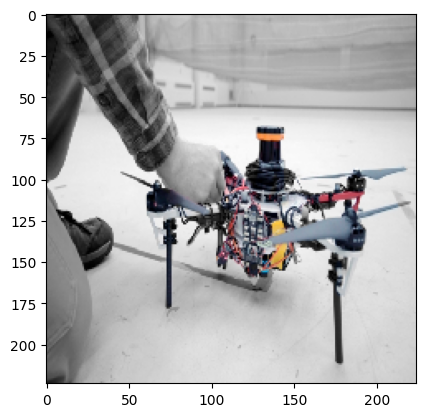

In [210]:
image = np.array(load_img(os.path.join(test_drone_dir, '00000221.jpg'), target_size=(224, 224, 3)))
plt.imshow(image)

In [220]:
model = ResNet50()

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(model)

layer_name: input_24      trainable: True
layer_name: conv1_pad     trainable: True
layer_name: conv1_conv    trainable: True
layer_name: conv1_bn      trainable: True
layer_name: conv1_relu    trainable: True
layer_name: pool1_pad     trainable: True
layer_name: pool1_pool    trainable: True
layer_name: conv2_block1_1_conv trainable: True
layer_name: conv2_block1_1_bn trainable: True
layer_name: conv2_block1_1_relu trainable: True
layer_name: conv2_block1_2_conv trainable: True
layer_name: conv2_block1_2_bn trainable: True
layer_name: conv2_block1_2_relu trainable: True
layer_name: conv2_block1_0_conv trainable: True
layer_name: conv2_block1_3_conv trainable: True
layer_name: conv2_block1_0_bn trainable: True
layer_name: conv2_block1_3_bn trainable: True
layer_name: conv2_block1_add trainable: True
layer_name: conv2_block1_out trainable: True
layer_name: conv2_block2_1_conv trainable: True
layer_name: conv2_block2_1_bn trainable: True
layer_name: conv2_block2_1_relu trainable: True
la

In [221]:
# We get the output of the last convolution layer. We then create a model that goes up to only that layer.

last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer

In [222]:
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
last_conv_layer_model

In [223]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [224]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [225]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [226]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [227]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [228]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

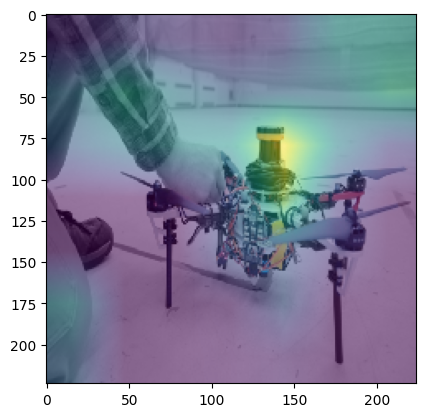

In [229]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)

In [230]:
multiobject_image = image

In [231]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(multiobject_image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [232]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [233]:
pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))

In [234]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [235]:
# Average over all the filters to get a single 2D array
ctfcl_gradcam = np.mean(last_conv_layer_output, axis=-1)
# Normalise the values
ctfcl_gradcam = np.clip(ctfcl_gradcam, 0, np.max(ctfcl_gradcam)) / np.max(ctfcl_gradcam)
ctfcl_gradcam = cv2.resize(ctfcl_gradcam, (224, 224))

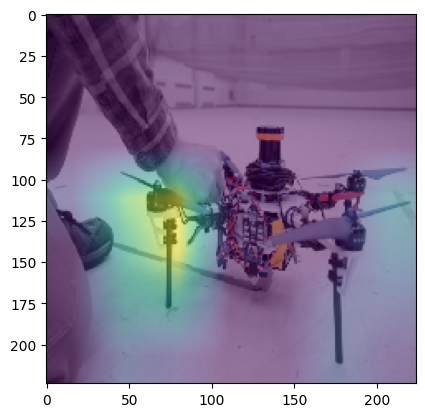

In [236]:
plt.imshow(multiobject_image)
plt.imshow(ctfcl_gradcam, alpha=0.5)

In [237]:
mask = cv2.resize(ctfcl_gradcam, (224, 224))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [238]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

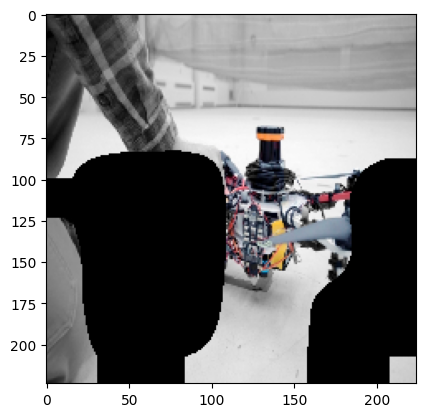

In [239]:
plt.imshow(ctfctl_image)

In [240]:
decode_predictions(model.predict(image[np.newaxis, ...]))

35363/35363 [==============================] - 0s 1us/step


[[('n03992509', "potter's_wheel", 0.36264658),
  ('n04179913', 'sewing_machine', 0.14161141),
  ('n04485082', 'tripod', 0.098831855),
  ('n03995372', 'power_drill', 0.089317456),
  ('n03888605', 'parallel_bars', 0.0522727)]]

In [241]:
decode_predictions(model.predict(ctfctl_image[np.newaxis, ...]))

1/1 [==============================] - 0s 32ms/step


[[('n04162706', 'seat_belt', 0.3364079),
  ('n04229816', 'ski_mask', 0.13174953),
  ('n03255030', 'dumbbell', 0.08978472),
  ('n04557648', 'water_bottle', 0.07034009),
  ('n03124170', 'cowboy_hat', 0.02775749)]]

In [242]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [243]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

In [244]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [245]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [246]:

for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [247]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

In [248]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

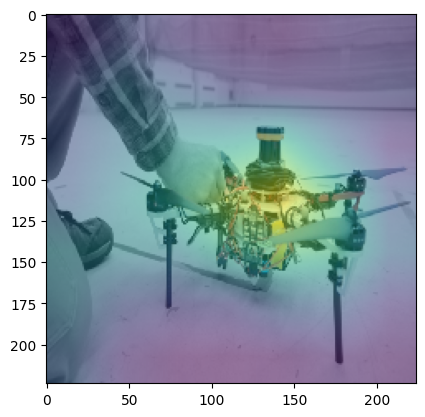

In [249]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

In [ ]:
###########################                      HIGH RESOLUTUIN                    ############################################

In [250]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [251]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [252]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [253]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [254]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

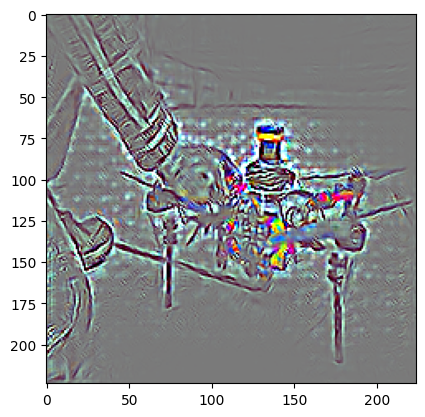

In [255]:
plt.imshow(saliency_map)